Loaded dataset 1: T3.csv (233 points)
Loaded dataset 3: T7.csv (233 points)


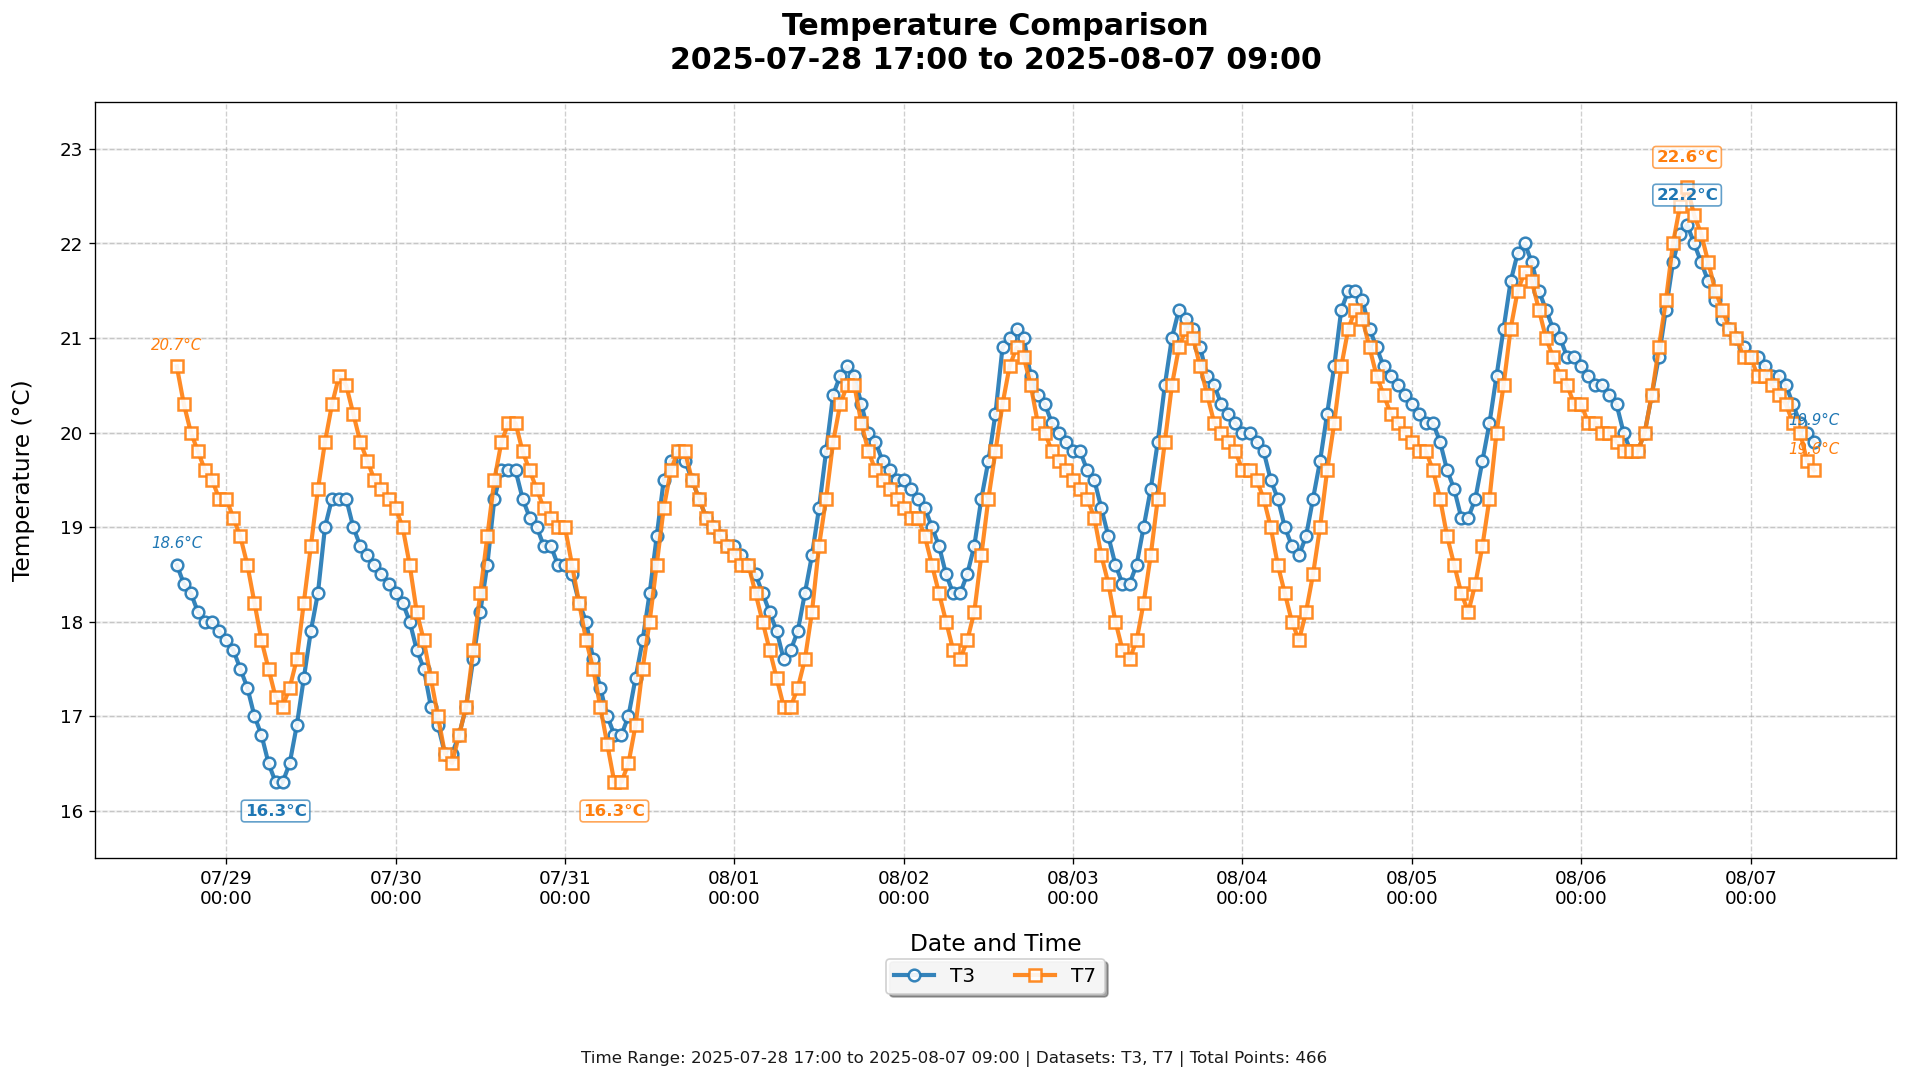


DATA SUMMARY:
Time Range: 2025-07-28 17:00 to 2025-08-07 09:00

Dataset 1: T3
  Points: 233
  Temperature Range: 16.3°C to 22.2°C
  First 3 points:
                       date_str time_str  temperature
datetime                                             
2025-07-28 17:00:00  2025.07.28    17:00         18.6
2025-07-28 18:00:00  2025.07.28    18:00         18.4
2025-07-28 19:00:00  2025.07.28    19:00         18.3

Dataset 2: T7
  Points: 233
  Temperature Range: 16.3°C to 22.6°C
  First 3 points:
                       date_str time_str  temperature
datetime                                             
2025-07-28 17:00:00  2025.07.28    17:00         20.7
2025-07-28 18:00:00  2025.07.28    18:00         20.3
2025-07-28 19:00:00  2025.07.28    19:00         20.0


In [6]:
# %% Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import os
from datetime import datetime

# %% Parameters (CUSTOMIZE THESE)
# =================================================================================
# Define your 6 dataset paths (update with actual file paths)
FILE_PATHS = [
    "T3.csv",
    "T4.csv",
    "T7.csv",
    "T8.csv",
    "T1.csv",
    "T2.csv"
]

# Set which datasets to plot (True = include, False = exclude)
PLOT_DATASETS = [True, False, True, False, False, False]  # Example: Plot datasets 1, 2 and 5

# Date/time range for filtering
START_DATETIME = "2025-07-28 17:00"  # Start date/time (YYYY-MM-DD HH:MM)
END_DATETIME = "2025-08-07 09:00"    # End date/time (YYYY-MM-DD HH:MM)
# =================================================================================

# %% Color palette for datasets (up to 6 colors)
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
MARKERS = ['o', 's', '^', 'D', 'v', 'p']  # Different markers for each dataset

# %% Read and process data function
def load_and_process_data(file_path):
    # Read only first three columns
    df = pd.read_csv(
        file_path,
        header=0,
        usecols=[0, 1, 2],
        names=['date_str', 'time_str', 'temperature'],
        dtype={'date_str': str, 'time_str': str}
    )
    
    # Combine date and time columns into datetime
    df['datetime'] = pd.to_datetime(
        df['date_str'] + ' ' + df['time_str'],
        format='%Y.%m.%d %H:%M',
        errors='coerce'
    )
    
    # Convert temperature to numeric, handling errors
    df['temperature'] = pd.to_numeric(df['temperature'], errors='coerce')
    
    # Drop rows with invalid datetime or temperature conversions
    df = df.dropna(subset=['datetime', 'temperature'])
    
    # Set datetime index and sort
    df = df.set_index('datetime').sort_index()
    return df

# Get dataset names from filenames
def get_dataset_name(file_path):
    return os.path.splitext(os.path.basename(file_path))[0]

# Load and filter selected datasets
start_dt = pd.to_datetime(START_DATETIME)
end_dt = pd.to_datetime(END_DATETIME)
datasets = []
dataset_names = []

for i, file_path in enumerate(FILE_PATHS):
    if i < len(PLOT_DATASETS) and PLOT_DATASETS[i]:
        try:
            df = load_and_process_data(file_path)
            filtered = df.loc[start_dt:end_dt]
            if not filtered.empty:
                datasets.append(filtered)
                dataset_names.append(get_dataset_name(file_path))
                print(f"Loaded dataset {i+1}: {file_path} ({len(filtered)} points)")
            else:
                print(f"Dataset {i+1} has no data in range: {file_path}")
        except Exception as e:
            print(f"Error loading dataset {i+1} ({file_path}): {str(e)}")

if not datasets:
    raise ValueError("No valid datasets to plot! Check your selections and data files.")

# %% Create professional comparison plot
plt.figure(figsize=(16, 9), dpi=120)
ax = plt.gca()

# Plot all selected datasets
lines = []
for i, (df, name) in enumerate(zip(datasets, dataset_names)):
    line, = ax.plot(
        df.index,
        df['temperature'],
        color=COLORS[i],
        linewidth=2.5,
        marker=MARKERS[i],
        markersize=7,
        markerfacecolor='white',
        markeredgewidth=1.5,
        alpha=0.9,
        zorder=3,
        label=name
    )
    lines.append(line)

# Formatting
plt.title(f"Temperature Comparison\n{start_dt.strftime('%Y-%m-%d %H:%M')} to {end_dt.strftime('%Y-%m-%d %H:%M')}", 
          fontsize=18, pad=20, fontweight='bold')
plt.xlabel("Date and Time", fontsize=14, labelpad=15)
plt.ylabel("Temperature (°C)", fontsize=14, labelpad=15)
plt.grid(True, linestyle='--', alpha=0.6, zorder=1)

# Date formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=0, ha='center', fontsize=11)

# Set y-axis limits
all_temps = pd.concat([df['temperature'] for df in datasets])
min_temp = np.floor(all_temps.min()) if not all_temps.empty else 0
max_temp = np.ceil(all_temps.max()) if not all_temps.empty else 1
plt.ylim(min_temp - 0.5, max_temp + 0.5)
plt.yticks(fontsize=11)

# Add horizontal temperature reference lines
if not all_temps.empty:
    for temp in np.arange(min_temp, max_temp + 1, 1):
        plt.axhline(y=temp, color='gray', linestyle='-', alpha=0.1, zorder=2)

# Add key point annotations
def annotate_key_points(df, color, name):
    if len(df) > 0:
        # First point
        plt.annotate(f"{df.iloc[0]['temperature']:.1f}°C", 
                     (df.index[0], df.iloc[0]['temperature']), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=9,
                     color=color,
                     fontstyle='italic')
        
        # Last point
        plt.annotate(f"{df.iloc[-1]['temperature']:.1f}°C", 
                     (df.index[-1], df.iloc[-1]['temperature']), 
                     textcoords="offset points", 
                     xytext=(0,10), 
                     ha='center',
                     fontsize=9,
                     color=color,
                     fontstyle='italic')
        
        # Max temperature
        max_idx = df['temperature'].idxmax()
        plt.annotate(f"{df.loc[max_idx]['temperature']:.1f}°C", 
                     (max_idx, df.loc[max_idx]['temperature']), 
                     textcoords="offset points", 
                     xytext=(0,15), 
                     ha='center',
                     fontsize=10,
                     color=color,
                     fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=color, alpha=0.7))
        
        # Min temperature
        min_idx = df['temperature'].idxmin()
        plt.annotate(f"{df.loc[min_idx]['temperature']:.1f}°C", 
                     (min_idx, df.loc[min_idx]['temperature']), 
                     textcoords="offset points", 
                     xytext=(0,-20), 
                     ha='center',
                     fontsize=10,
                     color=color,
                     fontweight='bold',
                     bbox=dict(boxstyle='round,pad=0.2', fc='white', ec=color, alpha=0.7))

for i, df in enumerate(datasets):
    annotate_key_points(df, COLORS[i], dataset_names[i])

# Add legend with enhanced styling
legend = plt.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.12),
    ncol=min(3, len(datasets)),
    frameon=True,
    framealpha=0.9,
    shadow=True,
    fancybox=True,
    fontsize=12
)

# Add footer text
selected_count = sum(PLOT_DATASETS)
footer_text = f"Time Range: {start_dt.strftime('%Y-%m-%d %H:%M')} to {end_dt.strftime('%Y-%m-%d %H:%M')} | "
footer_text += f"Datasets: {', '.join(dataset_names)} | "
footer_text += f"Total Points: {sum(len(df) for df in datasets)}"

plt.figtext(0.5, 0.01, footer_text, 
            ha="center", fontsize=10, alpha=0.9)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust for legend and footer
plt.show()

# Display data samples
print("\n" + "="*80)
print("DATA SUMMARY:")
print(f"Time Range: {START_DATETIME} to {END_DATETIME}")
for i, (name, df) in enumerate(zip(dataset_names, datasets)):
    print(f"\nDataset {i+1}: {name}")
    print(f"  Points: {len(df)}")
    print(f"  Temperature Range: {df['temperature'].min():.1f}°C to {df['temperature'].max():.1f}°C")
    print("  First 3 points:")
    print(df.head(3))
print("="*80)